# ORENIST Dynamic Filter Classification

**Note**: This notebook is designed to run on CPU (no GPU) runtime.

**[ODF-01]**

Install libraries.

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.6/185.6 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 4.9 MB/s eta 0:00:00
flax                          0.6.1
jax                           0.3.25
jaxlib                        0.3.25+cuda11.cudnn805
optax                         0.1.3


**[ODF-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

plt.rcParams.update({'font.size': 12})

**[ODF-03]**

Download ORENIST dataset and convert to DeviceArray objects.

In [3]:
!curl -LO https://github.com/enakai00/colab_jaxbook/raw/main/Chapter04/ORENIST.pkl
with open('ORENIST.pkl', 'rb') as file:
    images, labels = pickle.load(file)
images = jnp.asarray(images)
labels = jnp.asarray(labels)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0  1060k      0 --:--:-- --:--:-- --:--:-- 1060k


**[ODF-04]**

Define a classification model with dynamically trained filters.

In [4]:
class DynamicFilterClassificationModel(nn.Module):
  @nn.compact
  def __call__(self, x, get_logits=False,
               get_filter_output=False, get_pooling_output=False):
    x = x.reshape([-1, 28, 28, 1])
    x = nn.Conv(features=2, kernel_size=(5, 5), use_bias=False,
                name='ConvLayer')(x)
    x = jnp.abs(x)
    if get_filter_output:
      return x
    x = nn.max_pool(x, window_shape=(28, 28), strides=(28, 28))
    if get_pooling_output:
      return x
    x = x.reshape([x.shape[0], -1]) # Flatten
    x = nn.Dense(features=3)(x)
    if get_logits:
        return x
    x = nn.softmax(x)
    return x

**[ODF-05]**

Generate initial parameter values.

In [5]:
key, key1 = random.split(random.PRNGKey(0))
variables = DynamicFilterClassificationModel().init(key1, images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    ConvLayer: {
        kernel: (5, 5, 1, 2),
    },
    Dense_0: {
        bias: (3,),
        kernel: (2, 3),
    },
})

**[ODF-06]**

Create a TrainState object.

In [6]:
state = train_state.TrainState.create(
    apply_fn=DynamicFilterClassificationModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[ODF-07]**

Define a loss function as the categorical cross entoropy.

In [7]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[ODF-08]**

Define a function to apply the training steps for one epoch.

In [8]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[ODF-09]**

Repeat applying the training step.

In [9]:
%%time
loss_history, acc_history = [], []
for step in range(1, 2001):
  state, loss, acc = train_step(state, images, labels)
  loss_history.append(jax.device_get(loss).tolist())
  acc_history.append(jax.device_get(acc).tolist())
  if step % 200 == 0:
    print ('Step: {}, Loss: {:.4f}, Accuracy {:.4f}'.format(step, loss, acc))

Step: 200, Loss: 0.7782, Accuracy 0.6556
Step: 400, Loss: 0.5110, Accuracy 0.9667
Step: 600, Loss: 0.3131, Accuracy 0.9778
Step: 800, Loss: 0.1939, Accuracy 0.9778
Step: 1000, Loss: 0.1280, Accuracy 0.9889
Step: 1200, Loss: 0.0909, Accuracy 1.0000
Step: 1400, Loss: 0.0681, Accuracy 1.0000
Step: 1600, Loss: 0.0530, Accuracy 1.0000
Step: 1800, Loss: 0.0424, Accuracy 1.0000
Step: 2000, Loss: 0.0347, Accuracy 1.0000
CPU times: user 2min 16s, sys: 1.11 s, total: 2min 17s
Wall time: 1min 23s


**[ODF-10]**

Show charts of loss history / accuracy history.

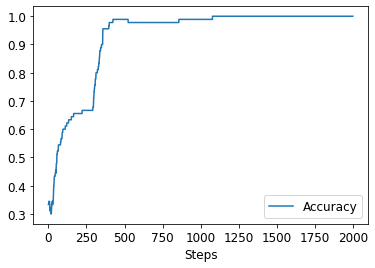

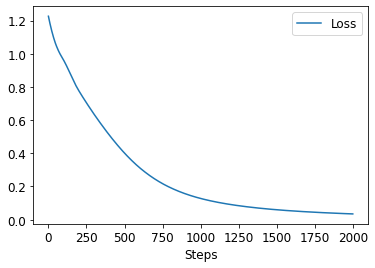

In [10]:
df = DataFrame({'Accuracy': acc_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

df = DataFrame({'Loss': loss_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

**[ODF-11]**

Show trained filters and filtered images.

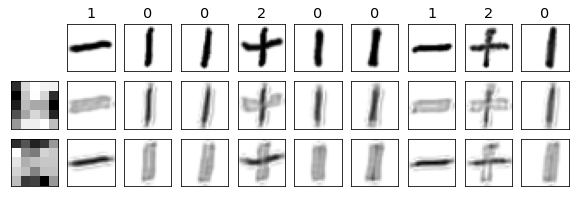

In [11]:
conv_output = jax.device_get(
    state.apply_fn({'params': state.params}, images[:9],
                   get_filter_output=True))
filter_vals = jax.device_get(state.params['ConvLayer']['kernel'])

fig = plt.figure(figsize=(10, 3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

v_max = np.max(conv_output)
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

**[ODF-12]**

Show trained filters and pooled images.

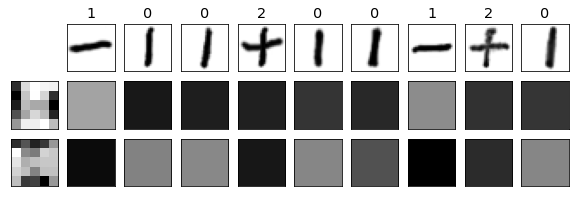

In [12]:
pool_output = jax.device_get(
    state.apply_fn({'params': state.params}, images[:9],
                   get_pooling_output=True))
filter_vals = jax.device_get(state.params['ConvLayer']['kernel'])

fig = plt.figure(figsize=(10, 3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

v_max = np.max(conv_output)
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

**[ODF-13]**

By looking into actual output values from the pooling layer, we found that the threshold to distingush "|" and "-" is 8.0. Convert the pooling output into the binary value with this threshold.

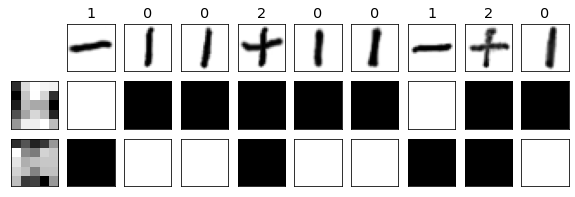

In [13]:
pool_output = jax.device_get(
    state.apply_fn({'params': state.params}, images[:9],
                   get_pooling_output=True))
bin_index = np.sign(pool_output-8.0)
filter_vals = jax.device_get(state.params['ConvLayer']['kernel'])

fig = plt.figure(figsize=(10, 3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

v_max = np.max(conv_output)
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(bin_index[i, :, :, 0],
                   vmin=-1, vmax=1, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(bin_index[i, :, :, 1],
                   vmin=-1, vmax=1, cmap=plt.cm.gray_r)